[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
2025-04-01 15:39:32,418 - INFO - Loading dataset...
2025-04-01 15:39:32,532 - INFO - Dropped 0 rows with missing text.
2025-04-01 15:39:32,533 - INFO - Starting sentiment analysis...
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Devic

          Date Release Date       Type Sentiment     Score  Positiveness  \
2   2024-12-18   2024-12-18  Statement   Neutral  0.997844      0.000000   
4   2024-11-07   2024-11-26     Minute   Neutral  0.986693      0.000000   
5   2024-11-07   2024-11-07  Statement   Neutral  0.997992      0.000000   
6   2024-09-18   2024-09-18  Statement   Neutral  0.973147      0.000000   
7   2024-09-18   2024-10-09     Minute  Negative  0.898571     -0.807430   
..         ...          ...        ...       ...       ...           ...   
197 2013-03-20   2013-04-10     Minute   Neutral  0.999997      0.000000   
198 2013-03-20   2013-03-20  Statement  Positive  0.990823      0.981729   
199 2013-01-30   2013-02-20     Minute   Neutral  0.999996      0.000000   
200 2013-01-30   2013-01-30  Statement  Positive  0.854480      0.730136   
201 2012-12-12   2013-01-03     Minute   Neutral  0.999997      0.000000   

    HawkishDovish  
2         Hawkish  
4         Hawkish  
5         Hawkish  
6      

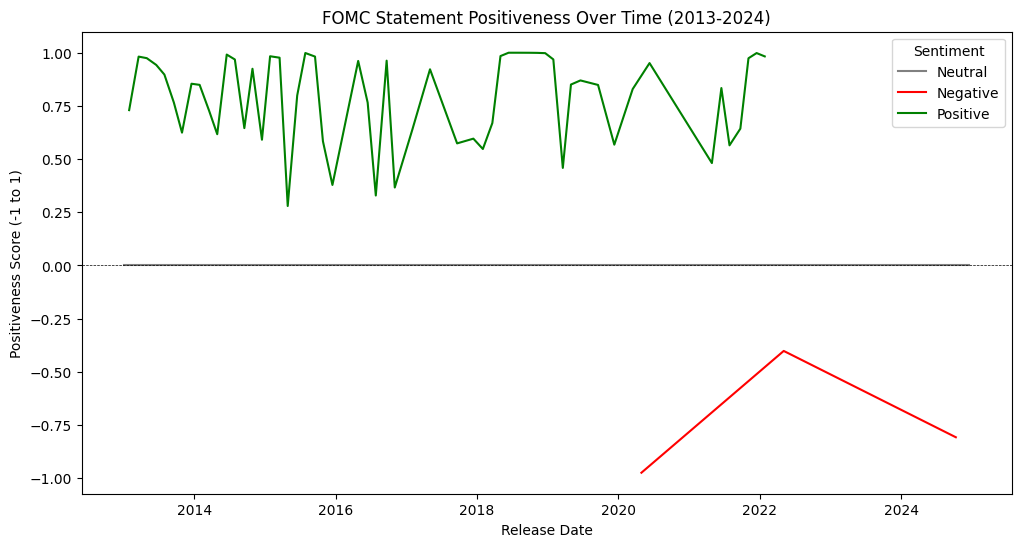

In [7]:
import pandas as pd
import numpy as np
from transformers import pipeline
from nltk.tokenize import sent_tokenize
import logging
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
import seaborn as sns

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Download NLTK data for sentence tokenization
import nltk
nltk.download('punkt')

def load_data(file_path, start_date="2013-01-01", end_date="2024-12-31"):
    """Load and filter the dataset."""
    logger.info("Loading dataset...")
    df = pd.read_csv(file_path, engine='python', parse_dates=['Date', 'Release Date'])
    
    # Filter by date range
    cutoff_start_date = pd.to_datetime(start_date)
    cutoff_end_date = pd.to_datetime(end_date)
    df = df[(df['Release Date'] >= cutoff_start_date) & (df['Release Date'] <= cutoff_end_date)]
    
    # Drop rows with missing text
    initial_len = len(df)
    df = df.dropna(subset=['Text'])
    logger.info(f"Dropped {initial_len - len(df)} rows with missing text.")
    
    return df

def chunk_text(text, tokenizer, max_length=500, use_chunks=True):
    """Chunk text into smaller pieces for sentiment analysis, respecting sentence boundaries."""
    if not use_chunks:
        tokens = tokenizer.encode(text, add_special_tokens=True, truncation=True, max_length=max_length)
        return [tokens]

    # Split text into sentences
    sentences = sent_tokenize(text)
    chunks = []
    current_chunk = []
    current_length = 0

    for sentence in sentences:
        tokens = tokenizer.encode(sentence, add_special_tokens=False)
        if current_length + len(tokens) > max_length - 2:  # Reserve space for [CLS] and [SEP]
            if current_chunk:  # If there's something in the current chunk, yield it
                chunk_tokens = [tokenizer.cls_token_id] + sum([tokenizer.encode(s, add_special_tokens=False) for s in current_chunk], []) + [tokenizer.sep_token_id]
                chunks.append(chunk_tokens)
            current_chunk = [sentence]
            current_length = len(tokens)
        else:
            current_chunk.append(sentence)
            current_length += len(tokens)

    # Handle the last chunk
    if current_chunk:
        chunk_tokens = [tokenizer.cls_token_id] + sum([tokenizer.encode(s, add_special_tokens=False) for s in current_chunk], []) + [tokenizer.sep_token_id]
        chunks.append(chunk_tokens)

    return chunks

def perform_sentiment_analysis(text, use_chunks=True):
    """Perform sentiment analysis on a text, handling chunks and aggregating results."""
    try:
        # Initialize the pipeline inside the function to avoid serialization issues
        finbert = pipeline('sentiment-analysis',
                           model='yiyanghkust/finbert-tone',
                           tokenizer='yiyanghkust/finbert-tone')
        tokenizer = finbert.tokenizer

        # Skip if text is too short
        if len(text.strip()) < 10:
            return "Neutral", 0.0, 0

        # Chunk the text (or not, depending on use_chunks)
        chunks = chunk_text(text, tokenizer, max_length=500, use_chunks=use_chunks)
        if not chunks:
            return "Neutral", 0.0, 0

        # Decode chunks for the pipeline
        decoded_chunks = [tokenizer.decode(chunk, skip_special_tokens=False) for chunk in chunks]
        
        # Perform sentiment analysis on all chunks at once
        results = finbert(decoded_chunks)
        
        sentiments = [result['label'] for result in results]
        scores = [result['score'] for result in results]

        # Log the sentiment distribution for this text
        logger.debug(f"Chunk sentiments: {sentiments}")
        logger.debug(f"Chunk scores: {scores}")

        # Weighted sentiment calculation (emphasize stronger sentiments)
        sentiment_map = {"Positive": 1, "Neutral": 0, "Negative": -1}
        weighted_scores = [sentiment_map[sent] * score**2 for sent, score in zip(sentiments, scores)]  # Square the score to emphasize stronger sentiments
        avg_weighted_score = sum(weighted_scores) / len(weighted_scores)

        # Log the weighted score for debugging
        logger.debug(f"Average weighted score: {avg_weighted_score}")

        # Determine overall sentiment with adjusted thresholds
        if avg_weighted_score > 0.05:  # Lowered threshold
            overall_sentiment = "Positive"
        elif avg_weighted_score < -0.05:  # Lowered threshold
            overall_sentiment = "Negative"
        else:
            overall_sentiment = "Neutral"

        # Calculate positiveness (normalized to -1 to 1)
        positiveness = avg_weighted_score

        # Average confidence score
        avg_score = sum(scores) / len(scores)

        return overall_sentiment, avg_score, positiveness

    except Exception as e:
        logger.error(f"Error processing text: {str(e)}")
        return "Neutral", 0.0, 0

def classify_hawkish_dovish(text):
    """Classify the text as Hawkish, Dovish, or Neutral based on keywords."""
    hawkish_keywords = ['inflation', 'tightening', 'rate hike', 'overheating', 'restrictive']
    dovish_keywords = ['stimulus', 'easing', 'accommodative', 'growth', 'supportive']
    
    text_lower = text.lower()
    hawkish_score = sum(text_lower.count(keyword) for keyword in hawkish_keywords)
    dovish_score = sum(text_lower.count(keyword) for keyword in dovish_keywords)

    if hawkish_score > dovish_score:
        return "Hawkish"
    elif dovish_score > hawkish_score:
        return "Dovish"
    else:
        return "Neutral"

def process_row(row, use_chunks=True):
    """Process a single row for sentiment analysis."""
    sentiment, score, positiveness = perform_sentiment_analysis(row['Text'], use_chunks=use_chunks)
    hawkish_dovish = classify_hawkish_dovish(row['Text'])
    return pd.Series([sentiment, score, positiveness, hawkish_dovish], index=['Sentiment', 'Score', 'Positiveness', 'HawkishDovish'])

def main():
    # Load data
    df = load_data('fomc.csv')

    # Parallelize sentiment analysis using ThreadPoolExecutor
    logger.info("Starting sentiment analysis...")
    with ThreadPoolExecutor(max_workers=4) as executor:
        results = list(executor.map(lambda row: process_row(row, use_chunks=False), [row for _, row in df.iterrows()]))

    # Add results to DataFrame
    df[['Sentiment', 'Score', 'Positiveness', 'HawkishDovish']] = pd.DataFrame(results, index=df.index)

    # Log summary
    logger.info("Sentiment analysis completed.")
    logger.info(f"Sentiment distribution:\n{df['Sentiment'].value_counts()}")
    logger.info(f"Hawkish/Dovish distribution:\n{df['HawkishDovish'].value_counts()}")

    # Print and save results
    print(df[['Date', 'Release Date', 'Type', 'Sentiment', 'Score', 'Positiveness', 'HawkishDovish']])
    df.to_csv('fomc_statement_with_sentiment.csv', index=False, sep='|')
    df.to_excel('fomc_statement_with_sentiment.xlsx', index=False)

    # Visualize Positiveness over time
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='Release Date', y='Positiveness', data=df, hue='Sentiment', palette={'Positive': 'green', 'Neutral': 'gray', 'Negative': 'red'})
    plt.title('FOMC Statement Positiveness Over Time (2013-2024)')
    plt.xlabel('Release Date')
    plt.ylabel('Positiveness Score (-1 to 1)')
    plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
    plt.savefig('fomc_positiveness_over_time.png')
    plt.show()

if __name__ == "__main__":
    main()

In [8]:
# number of positive, negative and neutral sentiments
sentiment_counts = df['Sentiment'].value_counts()

NameError: name 'df' is not defined

In [ ]:
sentiment_counts

Sentiment
Neutral     181
Positive     11
Negative      2
Name: count, dtype: int64